In [1]:
%matplotlib inline

import re
import cv2
import glob

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
path = "Signs/Final_Training/Images/"

sign_labels_dict = {
    "00000" : "20km/h",
    "00001" : "30km/h",
    "00002" : "50km/h",
    "00003" : "60km/h",
    "00004" : "70km/h",
    "00005" : "80km/h",
    "00006" : "end 80km/h",
    "00007" : "100km/h",
    "00008" : "120km/h",
    "00009" : "No pass",
    "00010" : "Passing to 3.5 metres",
    "00011" : "Right-of-way",
    "00012" : "Priority",
    "00013" : "Yield",
    "00014" : "Stop",
    "00015" : "No cars",
    "00016" : "To 3.5 tons",
    "00017" : "No pass",
    "00018" : "Caution",
    "00019" : "Left curve",
    "00020" : "Right curve",
    "00021" : "2 curves",
    "00022" : "Bumpy",
    "00023" : "Slippery road",
    "00024" : "Road narrows on the right",
    "00025" : "Road work",
    "00026" : "Traffic signals",
    "00027" : "Pedestrians",
    "00028" : "Children",
    "00029" : "Bicycles",
    "00030" : "Snow",
    "00031" : "Animals",
    "00032" : "End of limits",
    "00033" : "Turn right",
    "00034" : "Turn left",
    "00035" : "Straight",
    "00036" : "Straight or right",
    "00037" : "Straight or left",
    "00038" : "Keep right",
    "00039" : "Keep left",
    "00040" : "Traffic circle",
    "00041" : "End of no passing",
    "00042" : "End of no passing by vechiles over 3.5 metric tons"
}

In [3]:
#dataset http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset
def load_data(path):
    images = {}
    for directory in glob.glob(path+"*"):
        sign_one_type = []
        for filename in glob.glob(directory+'/*.ppm'): 
            image = cv2.imread(filename) 
            #Why gray? http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            resized_image = cv2.resize(gray_image, (32, 32)) 
            sign_one_type.append(resized_image)
        images[directory] = sign_one_type
    return images

def plot_bar(converted_dataset, title):
    plt.figure(figsize=(20,10))
    plt.xticks(rotation=90)
    plt.xlabel('Sign name', fontsize=18)
    plt.ylabel('Number of signs in set', fontsize=18)
    plt.title(title)
    plt.grid(True)
    plt.bar(list(converted_dataset.keys()), converted_dataset.values(), color='g', )
    plt.show()

def print_signs(images):
    for label in images.keys():
        print(label)
        i = 0
        for image in images[label]:
            plt.imshow(image, cmap="gray")
            plt.show()
            if i > 15:
                break
            i = i + 1
        
def create_plot_date(dataset, sign_labels_dict):
    sign_labels_dict = {path+k: v for k,v in sign_labels_dict.items()}
    plot_dict = {}
    for key in dataset.keys():
        plot_dict[sign_labels_dict[key]] = len(dataset[key])
    return plot_dict


In [4]:
images = load_data(path)

In [ ]:
#print_signs(images)

In [5]:
class Transformation():
    def __init__(self, images):
        self.images = images
        self.flip_horizontally = [path+'000'+index for index in ['11', '12', '13', '15', '17', '18', '22', '26', '30', '35']]
        self.flip_vertically   = [path+'000'+index for index in ['01', '05', '12', '15', '17']]
        self.flip_ver_and_hor  = [path+'000'+index for index in ['32', '40']]
        self.flip_alternately  = [[path+'000'+ i for i in index] for index in 
                             [['19', '20'],['33', '34'],['36', '37'],['38', '39']]]
        
    def run(self):
        self.transform_signs()
        
    def get_images(self):
        return self.images
        
    def transform_signs(self):
    
        for label in self.images:       
            if label in self.flip_horizontally:
                self.transform_into_same_sign(label, [1])
            elif label in self.flip_vertically:
                self.transform_into_same_sign(label, [0])
            elif label in self.flip_ver_and_hor:
                self.transform_into_same_sign(label, [1,-1])
            for flips in self.flip_alternately:
                for flip in flips:
                    if label in flip:
                        #take 0 as second index if label index is 1, else take 0
                        index = 1 - flips.index(label)
                        self.transform_into_other_sign(flip, flips[index])
            #rotate, translate etc.
            self.rotate_images(label)

    def transform_into_same_sign(self, label, flip_values):
        temp = []
        for image in self.images[label]:
            for flip_value in flip_values:
                flipped_image = cv2.flip( image, flip_value )
            temp.append(flipped_image)
        temp = np.array(temp)
        '''
        print(label)
        i = 0
        for image in temp:
            i = i + 1
            plt.imshow(image, cmap="gray")
            plt.show()
            if i > 5:
                break
        '''
        self.images[label] = np.concatenate((temp, self.images[label]))

    def transform_into_other_sign(self, label_to_transform, label_to_add):
        temp = []
        for image in self.images[label_to_transform]:
            flipped_image = cv2.flip( image, 1 )
            temp.append(flipped_image)
        temp = np.array(temp)
        '''
        print(label_to_add)
        i = 0
        for image in temp:
            i = i + 1
            plt.imshow(image, cmap="gray")
            plt.show()
            if i > 5:
                break
        '''
        self.images[label_to_add] = np.concatenate((temp, self.images[label_to_add]))

    def rotate_images(self, label):
        temp = []
        for image in self.images[label]:
            for i in range(15):
                rotated_image = self.rotate_image(image)
                temp.append(rotated_image)
        temp = np.array(temp)
        self.images[label] = np.concatenate((temp, self.images[label]))

    def rotate_image(self, image): 
        rows,cols = image.shape  

        rotation_angle = np.random.uniform(-10,10)
        rotation_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),rotation_angle,1)

        translation_value_x = np.random.uniform(-5,5)
        translation_value_y = np.random.uniform(-5,5)
        translation_matrix = np.float32([ [1,0,translation_value_x], [0,1,translation_value_y] ])

        affine_x = np.random.uniform(4,6)
        affine_y = np.random.uniform(24,26)
        #Coordinates of triangle vertices in the source image.
        src = np.float32([[5,5],[25,5],[5,25]])
        #Coordinates of the corresponding triangle vertices in the destination image.
        dst = np.float32([[affine_x,5],[affine_y,affine_x],[5,affine_y]])
        #https://docs.opencv.org/3.0-beta/_images/affine.jpg
        affine_matrix = cv2.getAffineTransform(src,dst)

        rotated_image = cv2.warpAffine(image, rotation_matrix, (cols,rows))
        translated_image = cv2.warpAffine(rotated_image, translation_matrix, (cols, rows))
        final_image = cv2.warpAffine(translated_image, affine_matrix, (cols, rows))

        return final_image

    def get_formatted_dataset(self, y = [], x = []):
        for label in self.images:
            feature = re.sub(
                        r"Signs/Final_Training/Images/(.*)",
                        r"\1",
                        label
                    )
            feature = int(feature)
            for image in self.images[label]:
                x.append(image)
                y.append(feature)
        return (np.array(x).astype(np.float32), np.array(y).astype(np.float32))

'''

plt.imshow(image, cmap="gray")
plt.show()
plt.imshow(flipped_image, cmap="gray")
plt.show()

'''

'\n\nplt.imshow(image, cmap="gray")\nplt.show()\nplt.imshow(flipped_image, cmap="gray")\nplt.show()\n\n'

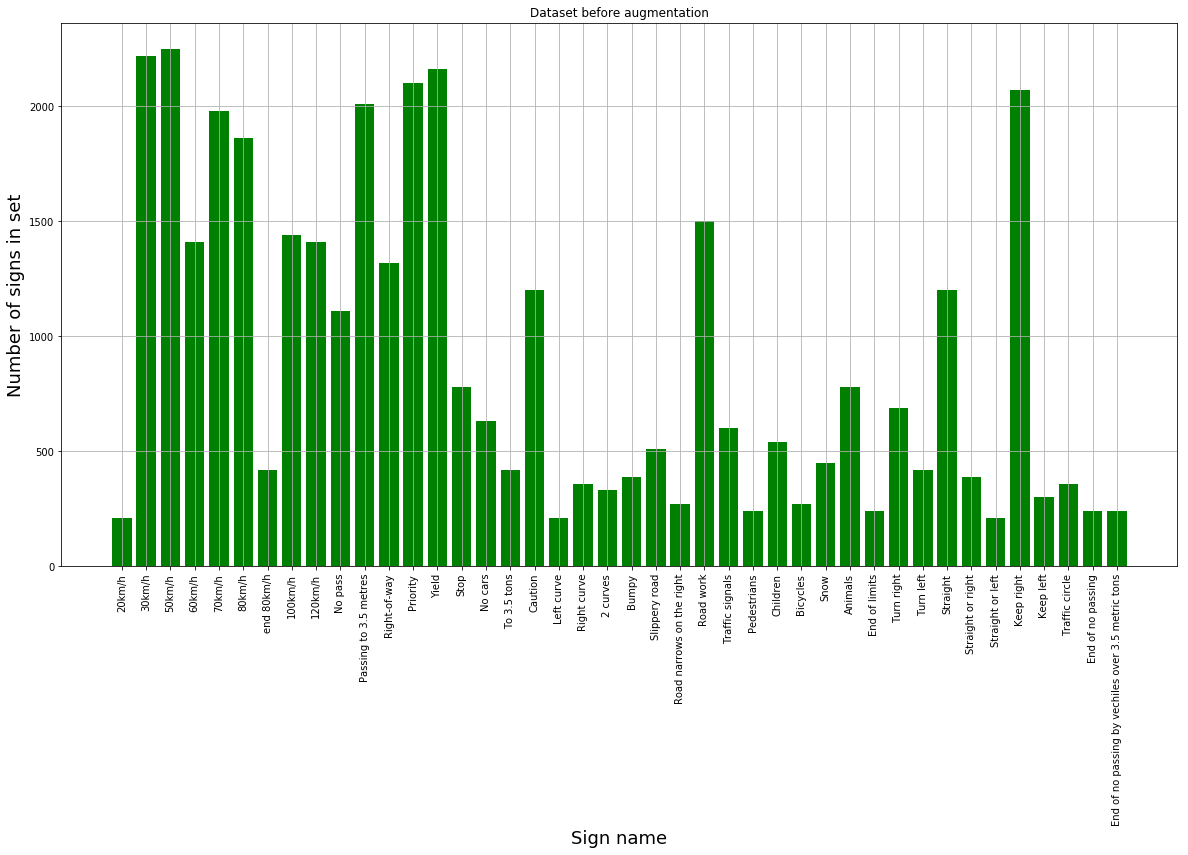

In [6]:
plot_bar(create_plot_date(images, sign_labels_dict), "Dataset before augmentation")

In [7]:
#TODO Improve pre-procesing: maybe image normalisation, some better augmentation (what about manipulating image brightness)
transformation = Transformation(images)
transformation.run() 

In [8]:
images_after_transformation = transformation.get_images() 

In [9]:
X, Y = transformation.get_formatted_dataset()
X, Y = shuffle(X,Y)

In [ ]:
print(len(X))
print(len(Y))
print(Y[1])
plt.imshow(X[1], cmap="gray")
plt.show()

In [ ]:
#print_signs(images)

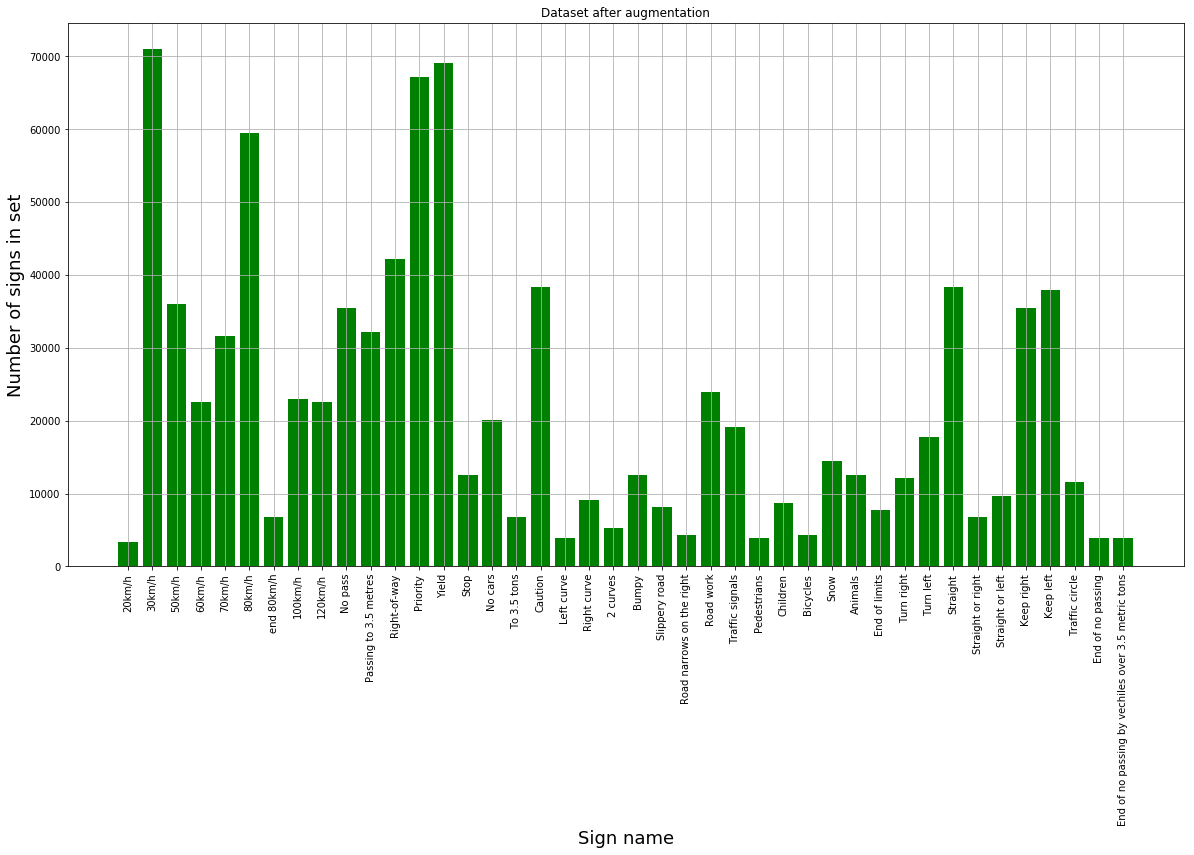

In [10]:
plot_bar(create_plot_date(images_after_transformation, sign_labels_dict), "Dataset after augmentation")

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
print(len(X))
print(len(X_train)+len(X_test))
print(len(Y))
print(len(Y_train)+len(Y_test))

In [ ]:
patent = "test"
def cnn_model_fn(features, labels, mode):
    is_training = True if mode == tf.estimator.ModeKeys.TRAIN else False
    is_predicting = True if mode == tf.estimator.ModeKeys.PREDICT else False
    is_evaling = True if mode == tf.estimator.ModeKeys.EVAL else False

    #print(optimizer_type)
    input_layer = tf.reshape(
        features, 
        [-1, 32, 32, 1]
    )
    print(patent)
    #TODO Rethink of schema. http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf

    #input  -> 
    #conv_1 -> pool_1  -> drop_1  ->
    #conv_2 -> pool_2  -> drop_2  -> 
    #conv_3 -> pool_3  -> drop_3  ->
    #flat   -> fc      -> drop_fc -> softmax
     
    #TODO Adjust dropouts depends on layer deep:http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
    #TODO Rethink of initializer (random, xavier, He-et-al)

    conv_layer_1 = tf.layers.conv2d(
        inputs = input_layer,
        filters = 32,
        kernel_size = 5,
        padding = 'same',
        activation = tf.nn.relu
    )
    
    pooling_layer_1 = tf.layers.max_pooling2d(
        inputs = conv_layer_1, 
        pool_size = [2, 2], 
        strides = 2
    )
    
    dropout_layer_1 = tf.layers.dropout(
        inputs = pooling_layer_1, 
        rate = 0.1, 
        training = is_training
    )    
    
    conv_layer_2 = tf.layers.conv2d(
        inputs = dropout_layer_1,
        filters = 64,
        kernel_size = 5,
        padding = 'same',
        activation = tf.nn.relu
    )
    
    pooling_layer_2 = tf.layers.max_pooling2d(
        inputs = conv_layer_2, 
        pool_size = [2, 2], 
        strides = 2
    )
    
    dropout_layer_2 = tf.layers.dropout(
        inputs = pooling_layer_2, 
        rate = 0.2, 
        training = is_training
    )  
    
    
    conv_layer_3 = tf.layers.conv2d(
        inputs = dropout_layer_2,
        filters = 128,
        kernel_size = 5,
        padding = 'same',
        activation = tf.nn.relu    
    )
    
    pooling_layer_3 = tf.layers.max_pooling2d(
        inputs = conv_layer_3, 
        pool_size = [2, 2], 
        strides = 2
    )
    
    dropout_layer_3 = tf.layers.dropout(
        inputs = pooling_layer_3, 
        rate = 0.3, 
        training = is_training
    )
    
    
    flatten_layer = tf.reshape(
        dropout_layer_3, 
        [-1, 4 * 4 * 128]
    )
    #TODO Adjust neurons in full connection layer 
    #(by experimenting https://datascience.stackexchange.com/questions/22760/number-and-size-of-dense-layers-in-a-cnn)
    full_connection_layer = tf.layers.dense(
        inputs = flatten_layer, 
        units = 1024, 
        activation = tf.nn.relu
    )
    
    dropout_layer_4 = tf.layers.dropout(
        inputs = full_connection_layer, 
        rate = 0.4, 
        training = is_training
    )

    #softmax
    #logits = tf.layers.dense(inputs=dropout, units=43)

    softmax_layer = tf.layers.dense(
        inputs = dropout_layer_4, 
        units = len(sign_labels_dict)
    )

    predictions = {
        "classes": tf.argmax(
            input = softmax_layer, 
            axis = 1
        ),
        "probabilities": tf.nn.softmax(
            logits = softmax_layer, 
            name = "softmax"
        )
    }

    if is_predicting:
        return tf.estimator.EstimatorSpec(
            mode = mode, 
            predictions = predictions
        )

    if is_training or is_evaling:
        loss = tf.losses.sparse_softmax_cross_entropy(
            labels = labels, 
            logits = softmax_layer
        )

        if is_training:
            #https://arxiv.org/abs/1712.07628
            #https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/
            #optimizers with different learning rate (at init 0.001)
            #TODO change optimizer depending on steps
            #global_step_value = 500
            '''
            global_step = tf.train.get_global_step()
            train_optimizer = tf.cond(tf.less(global_step_value, 1500),
                lambda: tf.train.AdamOptimizer().minimize(
                    loss = loss,
                    global_step = global_step
                ),
                lambda: tf.train.GradientDescentOptimizer(learning_rate=0.0001).minimize(
                    loss = loss,
                    global_step = global_step
                )
            )
            '''
            train_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001).minimize(
                loss = loss,
                global_step = tf.train.get_global_step()
            )
            '''
            train_optimizer =  tf.train.AdamOptimizer().minimize(
                loss = loss,
                global_step = tf.train.get_global_step()
            )
            '''
            return tf.estimator.EstimatorSpec(
                mode = mode, 
                loss = loss, 
                train_op = train_optimizer
            )

        if is_evaling:
            metrics = {
                "accuracy": tf.metrics.accuracy(
                    labels = labels, 
                    predictions = predictions["classes"]
                )
            }
            return tf.estimator.EstimatorSpec(
                mode = mode, 
                loss = loss, 
                eval_metric_ops = metrics
            )

In [ ]:
#Create the Estimator
classifier = tf.estimator.Estimator(
    model_fn = cnn_model_fn, 
    model_dir = "./tmp"
)

In [ ]:
#it's only for testing purpose, in normal training I will use full dataset
X1 = X_train[:20]
Y1 = Y_train[:20]
X2 = X_test[:100]
Y2 = Y_test[:100]

In [ ]:
logging_hook = tf.train.LoggingTensorHook(
    tensors = {
        "probabilities": "softmax"
    }, 
    every_n_iter = 25
)


In [ ]:
import csv
import sys
Y_train= Y_train.astype(np.int64)
Y_test= Y_test.astype(np.int64)

results = []
optimizers = ['adam', 'sgd']
optimizer = "sgd"
steps = [100]

lrs = [0.01, 0.001, 0.0001, 0.00001]
i = 0
for step in steps:
    def cnn_model_fn(features, labels, mode):
        is_training = True if mode == tf.estimator.ModeKeys.TRAIN else False
        is_predicting = True if mode == tf.estimator.ModeKeys.PREDICT else False
        is_evaling = True if mode == tf.estimator.ModeKeys.EVAL else False

        #print(optimizer_type)
        input_layer = tf.reshape(
            features, 
            [-1, 32, 32, 1]
        )

        #TODO Rethink of schema. http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf

        #input  -> 
        #conv_1 -> pool_1  -> drop_1  ->
        #conv_2 -> pool_2  -> drop_2  -> 
        #conv_3 -> pool_3  -> drop_3  ->
        #flat   -> fc      -> drop_fc -> softmax

        #TODO Adjust dropouts depends on layer deep:http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
        #TODO Rethink of initializer (random, xavier, He-et-al)

        conv_layer_1 = tf.layers.conv2d(
            inputs = input_layer,
            filters = 32,
            kernel_size = 5,
            padding = 'same',
            activation = tf.nn.relu
        )

        pooling_layer_1 = tf.layers.max_pooling2d(
            inputs = conv_layer_1, 
            pool_size = [2, 2], 
            strides = 2
        )

        dropout_layer_1 = tf.layers.dropout(
            inputs = pooling_layer_1, 
            rate = 0.1, 
            training = is_training
        )    

        conv_layer_2 = tf.layers.conv2d(
            inputs = dropout_layer_1,
            filters = 64,
            kernel_size = 5,
            padding = 'same',
            activation = tf.nn.relu
        )

        pooling_layer_2 = tf.layers.max_pooling2d(
            inputs = conv_layer_2, 
            pool_size = [2, 2], 
            strides = 2
        )

        dropout_layer_2 = tf.layers.dropout(
            inputs = pooling_layer_2, 
            rate = 0.2, 
            training = is_training
        )  


        conv_layer_3 = tf.layers.conv2d(
            inputs = dropout_layer_2,
            filters = 128,
            kernel_size = 5,
            padding = 'same',
            activation = tf.nn.relu    
        )

        pooling_layer_3 = tf.layers.max_pooling2d(
            inputs = conv_layer_3, 
            pool_size = [2, 2], 
            strides = 2
        )

        dropout_layer_3 = tf.layers.dropout(
            inputs = pooling_layer_3, 
            rate = 0.3, 
            training = is_training
        )


        flatten_layer = tf.reshape(
            dropout_layer_3, 
            [-1, 4 * 4 * 128]
        )
        #TODO Adjust neurons in full connection layer 
        #(by experimenting https://datascience.stackexchange.com/questions/22760/number-and-size-of-dense-layers-in-a-cnn)
        full_connection_layer = tf.layers.dense(
            inputs = flatten_layer, 
            units = 1024, 
            activation = tf.nn.relu
        )

        dropout_layer_4 = tf.layers.dropout(
            inputs = full_connection_layer, 
            rate = 0.4, 
            training = is_training
        )

        #softmax
        softmax_layer = tf.layers.dense(
            inputs = dropout_layer_4, 
            units = len(sign_labels_dict)
        )

        predictions = {
            "classes": tf.argmax(
                input = softmax_layer, 
                axis = 1
            ),
            "probabilities": tf.nn.softmax(
                logits = softmax_layer, 
                name = "softmax"
            )
        }

        if is_predicting:
            return tf.estimator.EstimatorSpec(
                mode = mode, 
                predictions = predictions
            )

        
        if is_training or is_evaling:
            #https://stackoverflow.com/questions/47034888/how-to-choose-cross-entropy-loss-in-tensorflow
            loss = tf.losses.sparse_softmax_cross_entropy(
                labels = labels, 
                logits = softmax_layer
            )

            if is_training:
                #https://arxiv.org/abs/1712.07628
                #https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/
                #optimizers with different learning rate (at init 0.001)
                #TODO change optimizer depending on steps
                #global_step_value = 500
                '''
                global_step = tf.train.get_global_step()
                train_optimizer = tf.cond(tf.less(global_step_value, 1500),
                    lambda: tf.train.AdamOptimizer().minimize(
                        loss = loss,
                        global_step = global_step
                    ),
                    lambda: tf.train.GradientDescentOptimizer(learning_rate=0.0001).minimize(
                        loss = loss,
                        global_step = global_step
                    )
                )
                '''
                train_optimizer =  tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(
                    loss = loss,
                    global_step = tf.train.get_global_step()
                )
                
                accuracy = tf.metrics.accuracy(
                    labels = labels, 
                    predictions = predictions["classes"],
                    name = "accuracy"
                )
                
                mse = tf.metrics.mean_absolute_error(
                    labels = labels, 
                    predictions = predictions["classes"],
                    name = "mse"
                )

                tf.summary.scalar("accuracy", accuracy[1])
                tf.summary.scalar("MSE", mse[1])

                eval_metric_ops = {
                    "accuracy" : accuracy,
                    "MSE" : mse
                }

                return tf.estimator.EstimatorSpec(
                    mode = mode, 
                    loss = loss, 
                    train_op = train_optimizer,
                    eval_metric_ops = eval_metric_ops
                )

            if is_evaling:
                accuracy = tf.metrics.accuracy(
                    labels = labels, 
                    predictions = predictions["classes"],
                    name = "accuracy"
                )
                mse = tf.metrics.mean_absolute_error(
                    labels = labels, 
                    predictions = predictions["classes"],
                    name = "mse"
                )

                tf.summary.scalar("accuracy", accuracy[1])
                tf.summary.scalar("MSE", mse[1])

                eval_metric_ops = {
                    "accuracy" : accuracy,
                    "MSE" : mse
                }
                return tf.estimator.EstimatorSpec(
                    mode = mode, 
                    loss = loss, 
                    eval_metric_ops = eval_metric_ops
                )

    config = tf.estimator.RunConfig(
        save_summary_steps = 10,
        model_dir = "./"+optimizer+str(i)
    )

    #Create the Estimator
    classifier = tf.estimator.Estimator(
        model_fn = cnn_model_fn, 
        config = config
    )

    logging_hook = tf.train.LoggingTensorHook(
        tensors = {
            "probabilities": "softmax"
        },
        every_n_iter = 25
    )

    #Perform training model
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = X_train,
        y = Y_train,
        batch_size = 100,
        num_epochs = None,
        shuffle = True
    )
    #Steps should be set to something bigger (need to adjust it)
    classifier.train(
        input_fn = train_input_fn,
        steps = step,
        hooks = [logging_hook]
    )
    # Evaluating the model
    evaluating_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = X_test,
        y = Y_test,
        num_epochs = 1,
        shuffle = False
    )
    print (classifier.evaluate(input_fn = evaluating_input_fn))
    i = i + 1


In [ ]:
    with open('result_list.csv', 'a') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([i,step,0.001,'adam+sgd'])
    i = i + 1

def get_formatted_dataset(images, y = [], x = []):
    for label in images:
        feature = re.sub(
                    r"Signs/Final_Training/Images/(.*)",
                    r"\1",
                    label
                )
        feature = int(feature)
        for image in images[label]:
            x.append(image)
            y.append(feature)
    return (np.array(x).astype(np.float32), np.array(y).astype(np.int32))

x3, y3 = get_formatted_dataset(images)

In [ ]:
# Evaluating the model
evaluating_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = x3,
    y = y3,
    num_epochs = 1,
    shuffle = False
)
print (classifier.evaluate(input_fn = evaluating_input_fn))

In [ ]:
# Evaluating the model
evaluating_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = X_test,
    y = Y_test,
    num_epochs = 1,
    shuffle = False
)
print (classifier.evaluate(input_fn = evaluating_input_fn))

In [49]:
import csv
import sys

Y_train = Y_train.astype(np.int64)
Y_test = Y_test.astype(np.int64)

optimizers = ['sgd']
steps = [1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
lrs = [0.01, 0.001, 0.0001]
i = 0
files = [4]
optimizer = 'sgd'
for file in files:
    for step in steps:
        for lr in lrs:
            def cnn_model_fn(features, labels, mode):
                is_training = True if mode == tf.estimator.ModeKeys.TRAIN else False
                is_predicting = True if mode == tf.estimator.ModeKeys.PREDICT else False
                is_evaling = True if mode == tf.estimator.ModeKeys.EVAL else False

                input_layer = tf.reshape(
                    features, 
                    [-1, 32, 32, 1]
                )

                conv_layer_1 = tf.layers.conv2d(
                    inputs = input_layer,
                    filters = 32,
                    kernel_size = 5,
                    padding = 'same',
                    activation = tf.nn.relu
                )

                pooling_layer_1 = tf.layers.max_pooling2d(
                    inputs = conv_layer_1, 
                    pool_size = [2, 2], 
                    strides = 2
                )

                dropout_layer_1 = tf.layers.dropout(
                    inputs = pooling_layer_1, 
                    rate = 0.1, 
                    training = is_training
                )    

                conv_layer_2 = tf.layers.conv2d(
                    inputs = dropout_layer_1,
                    filters = 64,
                    kernel_size = 5,
                    padding = 'same',
                    activation = tf.nn.relu
                )

                pooling_layer_2 = tf.layers.max_pooling2d(
                    inputs = conv_layer_2, 
                    pool_size = [2, 2], 
                    strides = 2
                )

                dropout_layer_2 = tf.layers.dropout(
                    inputs = pooling_layer_2, 
                    rate = 0.2, 
                    training = is_training
                )  


                conv_layer_3 = tf.layers.conv2d(
                    inputs = dropout_layer_2,
                    filters = 128,
                    kernel_size = 5,
                    padding = 'same',
                    activation = tf.nn.relu    
                )

                pooling_layer_3 = tf.layers.max_pooling2d(
                    inputs = conv_layer_3, 
                    pool_size = [2, 2], 
                    strides = 2
                )

                dropout_layer_3 = tf.layers.dropout(
                    inputs = pooling_layer_3, 
                    rate = 0.3, 
                    training = is_training
                )


                flatten_layer = tf.reshape(
                    dropout_layer_3, 
                    [-1, 4 * 4 * 128]
                )

                full_connection_layer = tf.layers.dense(
                    inputs = flatten_layer, 
                    units = 1024, 
                    activation = tf.nn.relu
                )

                dropout_layer_4 = tf.layers.dropout(
                    inputs = full_connection_layer, 
                    rate = 0.4, 
                    training = is_training
                )

                #softmax
                softmax_layer = tf.layers.dense(
                    inputs = dropout_layer_4, 
                    units = len(sign_labels_dict)
                )

                predictions = {
                    "classes": tf.argmax(
                        input = softmax_layer, 
                        axis = 1
                    ),
                    "probabilities": tf.nn.softmax(
                        logits = softmax_layer, 
                        name = "softmax"
                    )
                }

                if is_predicting:
                    return tf.estimator.EstimatorSpec(
                        mode = mode, 
                        predictions = predictions
                    )

                loss = tf.losses.sparse_softmax_cross_entropy(
                    labels = labels, 
                    logits = softmax_layer
                )
                accuracy = tf.metrics.accuracy(
                    labels = labels, 
                    predictions = predictions["classes"]
                )

                mae = tf.metrics.mean_absolute_error(
                    labels = labels, 
                    predictions = predictions["classes"]
                )
                mse = tf.metrics.mean_squared_error(
                    labels = labels, 
                    predictions = predictions["classes"]
                )

                metrics = {
                    "accuracy" : accuracy,
                    "mae": mae,
                    "mse": mse
                }

                tf.summary.scalar("accuracy", accuracy[1])
                tf.summary.scalar("loss", loss)
                tf.logging.set_verbosity(tf.logging.INFO)
                tf.summary.merge_all()

                if is_training:
                    if optimizer == 'adam':
                        train_optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(
                            loss = loss,
                            global_step = tf.train.get_global_step()
                        )
                    elif optimizer == 'sgd':
                        train_optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(
                            loss = loss,
                            global_step = tf.train.get_global_step()
                        )

                    return tf.estimator.EstimatorSpec(
                        mode = mode, 
                        loss = loss, 
                        train_op = train_optimizer
                    )

                if is_evaling:
                    return tf.estimator.EstimatorSpec(
                        mode = mode, 
                        loss = loss, 
                        eval_metric_ops = metrics
                    )

            
            config = tf.estimator.RunConfig(
                save_summary_steps = 10,
                model_dir = "./adam+"+optimizer+"/" + str(file)+"+"+str(step)+"+"+str(lr)
            )

            classifier = tf.estimator.Estimator(
                model_fn = cnn_model_fn, 
                config = config
            )

            train_input_fn = tf.estimator.inputs.numpy_input_fn(
                x = X_train,
                y = Y_train,
                batch_size = 100,
                num_epochs = None,
                shuffle = True
            )

            classifier.train(
                input_fn = train_input_fn,
                steps = step
            )

            evaluating_input_fn = tf.estimator.inputs.numpy_input_fn(
                x = X_test,
                y = Y_test,
                num_epochs = 1,
                shuffle = False
            )
            output = classifier.evaluate(input_fn = evaluating_input_fn)
            output =  re.findall(
                r"{'accuracy': (.*), 'loss': (.*), 'mae': (.*), 'mse': (.*), 'global_step': (.*)}",
                str(output)
            )
            acc = output[0][0]
            loss = output[0][1]
            mae = output[0][2]
            mse = output[0][3]
            with open('result_list.csv', 'a') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow([i,optimizer,step, lr,acc,loss,mae,mse])
            i = i + 1

INFO:tensorflow:Using config: {'_model_dir': './adam/0', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x15c95da90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./adam/0/model.ckpt.
INFO:tensorflow:loss = 41.91611, step = 1
INFO:tensorflow:global_s

INFO:tensorflow:Loss for final step: 3.2600756.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-15-16:11:05
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./adam/3/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-08-15-16:13:24
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.07366, global_step = 1000, loss = 3.438485, mae = 9.941779, mse = 165.21054
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: ./adam/3/model.ckpt-1000
INFO:tensorflow:Using config: {'_model_dir': './adam/4', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': No

INFO:tensorflow:Saving checkpoints for 1500 into ./adam/6/model.ckpt.
INFO:tensorflow:Loss for final step: 3.3656714.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-15-16:32:42
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./adam/6/model.ckpt-1500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-08-15-16:35:12
INFO:tensorflow:Saving dict for global step 1500: accuracy = 0.071211055, global_step = 1500, loss = 3.4368837, mae = 9.999435, mse = 173.61877
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1500: ./adam/6/model.ckpt-1500
INFO:tensorflow:Using config: {'_model_dir': './adam/7', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000

INFO:tensorflow:global_step/sec: 3.64963
INFO:tensorflow:loss = 3.4517567, step = 401 (27.400 sec)
INFO:tensorflow:global_step/sec: 3.66345
INFO:tensorflow:loss = 3.4040408, step = 501 (27.297 sec)
INFO:tensorflow:global_step/sec: 3.45811
INFO:tensorflow:loss = 3.3647454, step = 601 (28.918 sec)
INFO:tensorflow:global_step/sec: 3.33323
INFO:tensorflow:loss = 3.3630905, step = 701 (30.000 sec)
INFO:tensorflow:global_step/sec: 3.53253
INFO:tensorflow:loss = 3.4748225, step = 801 (28.309 sec)
INFO:tensorflow:global_step/sec: 3.66335
INFO:tensorflow:loss = 3.418905, step = 901 (27.297 sec)
INFO:tensorflow:global_step/sec: 3.67595
INFO:tensorflow:loss = 3.4843855, step = 1001 (27.204 sec)
INFO:tensorflow:global_step/sec: 3.6813
INFO:tensorflow:loss = 3.429459, step = 1101 (27.165 sec)
INFO:tensorflow:global_step/sec: 3.68853
INFO:tensorflow:loss = 3.4657638, step = 1201 (27.111 sec)
INFO:tensorflow:global_step/sec: 3.67805
INFO:tensorflow:loss = 3.4799144, step = 1301 (27.188 sec)
INFO:tens

INFO:tensorflow:global_step/sec: 3.88188
INFO:tensorflow:loss = 2.8553045, step = 1401 (25.761 sec)
INFO:tensorflow:global_step/sec: 3.95414
INFO:tensorflow:loss = 2.4768286, step = 1501 (25.290 sec)
INFO:tensorflow:global_step/sec: 3.89804
INFO:tensorflow:loss = 2.6654706, step = 1601 (25.654 sec)
INFO:tensorflow:global_step/sec: 3.89559
INFO:tensorflow:loss = 2.381239, step = 1701 (25.670 sec)
INFO:tensorflow:global_step/sec: 3.9081
INFO:tensorflow:loss = 2.0797079, step = 1801 (25.588 sec)
INFO:tensorflow:global_step/sec: 3.89345
INFO:tensorflow:loss = 2.1449242, step = 1901 (25.684 sec)
INFO:tensorflow:Saving checkpoints for 2000 into ./adam/11/model.ckpt.
INFO:tensorflow:Loss for final step: 2.154919.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-15-17:25:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./adam/11/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:ten

INFO:tensorflow:loss = 0.46043935, step = 1801 (26.302 sec)
INFO:tensorflow:global_step/sec: 3.79983
INFO:tensorflow:loss = 0.5907925, step = 1901 (26.317 sec)
INFO:tensorflow:global_step/sec: 3.78926
INFO:tensorflow:loss = 0.5857532, step = 2001 (26.389 sec)
INFO:tensorflow:global_step/sec: 3.79947
INFO:tensorflow:loss = 0.68506056, step = 2101 (26.319 sec)
INFO:tensorflow:global_step/sec: 3.7954
INFO:tensorflow:loss = 0.5451017, step = 2201 (26.348 sec)
INFO:tensorflow:global_step/sec: 3.79473
INFO:tensorflow:loss = 0.65782225, step = 2301 (26.352 sec)
INFO:tensorflow:Saving checkpoints for 2343 into ./adam/13/model.ckpt.
INFO:tensorflow:global_step/sec: 3.76837
INFO:tensorflow:loss = 0.5831985, step = 2401 (26.537 sec)
INFO:tensorflow:Saving checkpoints for 2500 into ./adam/13/model.ckpt.
INFO:tensorflow:Loss for final step: 0.6172808.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-15-17:51:10
INFO:tensorflow:G

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./sgd/16/model.ckpt.
INFO:tensorflow:loss = 26.204218, step = 1
INFO:tensorflow:global_step/sec: 3.7418
INFO:tensorflow:loss = 3.7281737, step = 101 (26.727 sec)
INFO:tensorflow:global_step/sec: 3.76587
INFO:tensorflow:loss = 3.7068355, step = 201 (26.554 sec)
INFO:tensorflow:global_step/sec: 3.75432
INFO:tensorflow:loss = 3.4569607, step = 301 (26.636 sec)
INFO:tensorflow:global_step/sec: 3.53597
INFO:tensorflow:loss = 3.6033833, step = 401 (28.281 sec)
INFO:tensorflow:Saving checkpoints for 500 into ./sgd/16/model.ckpt.
INFO:tensorflow:Loss for final step: 3.502771.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-15-18:14:10
INFO:tenso

INFO:tensorflow:Starting evaluation at 2018-08-15-18:32:36
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./sgd/19/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-08-15-18:34:54
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.100475945, global_step = 1000, loss = 3.478219, mae = 13.9941225, mse = 339.46103
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: ./sgd/19/model.ckpt-1000
INFO:tensorflow:Using config: {'_model_dir': './sgd/20', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x129722550>, '

INFO:tensorflow:global_step/sec: 3.92486
INFO:tensorflow:loss = 3.584547, step = 1101 (25.479 sec)
INFO:tensorflow:global_step/sec: 3.8615
INFO:tensorflow:loss = 3.4142675, step = 1201 (25.897 sec)
INFO:tensorflow:global_step/sec: 3.90288
INFO:tensorflow:loss = 3.5967512, step = 1301 (25.622 sec)
INFO:tensorflow:global_step/sec: 3.88214
INFO:tensorflow:loss = 3.5238783, step = 1401 (25.759 sec)
INFO:tensorflow:Saving checkpoints for 1500 into ./sgd/22/model.ckpt.
INFO:tensorflow:Loss for final step: 3.4504955.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-15-18:56:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./sgd/22/model.ckpt-1500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-08-15-18:59:03
INFO:tensorflow:Saving dict for global step 1500: accuracy = 0.088598564, global_step = 1500, loss = 3.484

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./sgd/25/model.ckpt.
INFO:tensorflow:loss = 25.215012, step = 1
INFO:tensorflow:global_step/sec: 3.57495
INFO:tensorflow:loss = 3.6175466, step = 101 (27.974 sec)
INFO:tensorflow:global_step/sec: 3.59513
INFO:tensorflow:loss = 3.6804988, step = 201 (27.815 sec)
INFO:tensorflow:global_step/sec: 3.60388
INFO:tensorflow:loss = 3.647353, step = 301 (27.748 sec)
INFO:tensorflow:global_step/sec: 3.53649
INFO:tensorflow:loss = 3.5932994, step = 401 (28.277 sec)
INFO:tensorflow:global_step/sec: 3.58341
INFO:tensorflow:loss = 3.501161, step = 501 (27.906 sec)
INFO:tensorflow:global_step/sec: 3.56156
INFO:tensorflow:loss = 3.6133642, step = 601 (28.078 sec)
INFO:tensorflow:global_step/sec: 3.62976
INFO:tensorflow:loss

INFO:tensorflow:global_step/sec: 4.09833
INFO:tensorflow:loss = 3.1184402, step = 801 (24.400 sec)
INFO:tensorflow:global_step/sec: 4.12727
INFO:tensorflow:loss = 3.103979, step = 901 (24.229 sec)
INFO:tensorflow:global_step/sec: 4.10488
INFO:tensorflow:loss = 3.1248093, step = 1001 (24.361 sec)
INFO:tensorflow:global_step/sec: 4.11602
INFO:tensorflow:loss = 3.1133947, step = 1101 (24.296 sec)
INFO:tensorflow:global_step/sec: 4.07977
INFO:tensorflow:loss = 3.190093, step = 1201 (24.511 sec)
INFO:tensorflow:global_step/sec: 4.1271
INFO:tensorflow:loss = 2.7366889, step = 1301 (24.230 sec)
INFO:tensorflow:global_step/sec: 4.12893
INFO:tensorflow:loss = 2.704903, step = 1401 (24.220 sec)
INFO:tensorflow:global_step/sec: 4.13927
INFO:tensorflow:loss = 2.9271002, step = 1501 (24.158 sec)
INFO:tensorflow:global_step/sec: 4.09761
INFO:tensorflow:loss = 2.6133575, step = 1601 (24.405 sec)
INFO:tensorflow:global_step/sec: 4.0979
INFO:tensorflow:loss = 2.547949, step = 1701 (24.403 sec)
INFO:ten

INFO:tensorflow:global_step/sec: 3.90366
INFO:tensorflow:loss = 3.7187524, step = 701 (25.616 sec)
INFO:tensorflow:global_step/sec: 3.93196
INFO:tensorflow:loss = 3.6396484, step = 801 (25.433 sec)
INFO:tensorflow:global_step/sec: 3.92422
INFO:tensorflow:loss = 3.7240741, step = 901 (25.483 sec)
INFO:tensorflow:global_step/sec: 3.91253
INFO:tensorflow:loss = 3.744225, step = 1001 (25.559 sec)
INFO:tensorflow:global_step/sec: 3.93862
INFO:tensorflow:loss = 3.6548443, step = 1101 (25.389 sec)
INFO:tensorflow:global_step/sec: 3.7362
INFO:tensorflow:loss = 3.7018187, step = 1201 (26.766 sec)
INFO:tensorflow:global_step/sec: 4.04973
INFO:tensorflow:loss = 3.5327497, step = 1301 (24.693 sec)
INFO:tensorflow:global_step/sec: 3.8283
INFO:tensorflow:loss = 3.7012331, step = 1401 (26.122 sec)
INFO:tensorflow:global_step/sec: 3.56648
INFO:tensorflow:loss = 3.6416607, step = 1501 (28.038 sec)
INFO:tensorflow:global_step/sec: 3.95841
INFO:tensorflow:loss = 3.5964284, step = 1601 (25.263 sec)
INFO:t